In [1]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.utils import reorder_points
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from helpers.descriptors import computePolygonArea, centre_of_gravity
from tqdm import tqdm as tqdm
from scipy.optimize import minimize
from helpers.rotation import RotateFromTo
import open3d as o3d
import os
import matplotlib as mpl

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


We use a simple example to test out the centreline finding algorithm. We do it three different ways. 

1. Use a starting point and iteratively find the best forward looking sections (find normal vector minimizing the sections), then move along the passage and repeat. 
2. Digitise a 2d line in CloudCompare, save it as a vector of 2d coordinates, then interpolate the surrounding point altitude to get the third dimension.
3. Use existing cloud contraction algorithms (implement for a cave point cloud the algorithm using Laplacian Based contraction (LBC) to extract the curve skeleton.

Our test dataset is a simple meander passage from Archamps cave. 

<img src= "../../real_data/16_Archamps/output/Archamps3d_PLAN2_occlusion.jpeg" width=400px><img src= "../../real_data/16_Archamps/output/Archamps3d_PLAN_occlusion.jpeg" width=210px>


*Plan view (left) and 3D view (right) of Archamps meander. Greyscale colours indicate the ambient occlusion value for each point*


After calculating normals for each point by best fitting a plane within a 8 cm radius, we use screened Poisson reconstruction to build a mesh of the cave. 

<img src= "../../real_data/16_Archamps/output/Archamps3d_PLAN_mesh.jpeg" width=600px>

*3D view (right) of Archamps meander as a mesh. Octree reconstruction depth of 8*

# 2 After Benoit Noetinger's thoughts. 

At this point, we have to start cutting the passage into sections and make a few assumptions. 
1. there are no branches
2. the process should yield the same centreline whether starting from one end or the other.

To find the starting points, we can extract the vertices of the mesh and find the eigenvectors of the 3d coordinate of the covariance matrix $\mathbf{\Sigma}$. This tells us in which direction our best-initial estimate for the plane normal vectors should be. 

In [2]:
# read the mesh
mesh = pv.read(f"../../real_data/16_Archamps/output/Meandre_1_clean.stl").extract_surface().triangulate()
# extract the pointcloud. 
pc = np.array(mesh.cast_to_pointset().points)
X = (pc - np.mean(pc, axis = 0))

In [3]:
Sigma =  X.T @ X

In [4]:
D, S = np.linalg.eig(Sigma)

In [5]:
D = np.diag(D)

In [6]:
C = np.mean(pc, axis = 0)

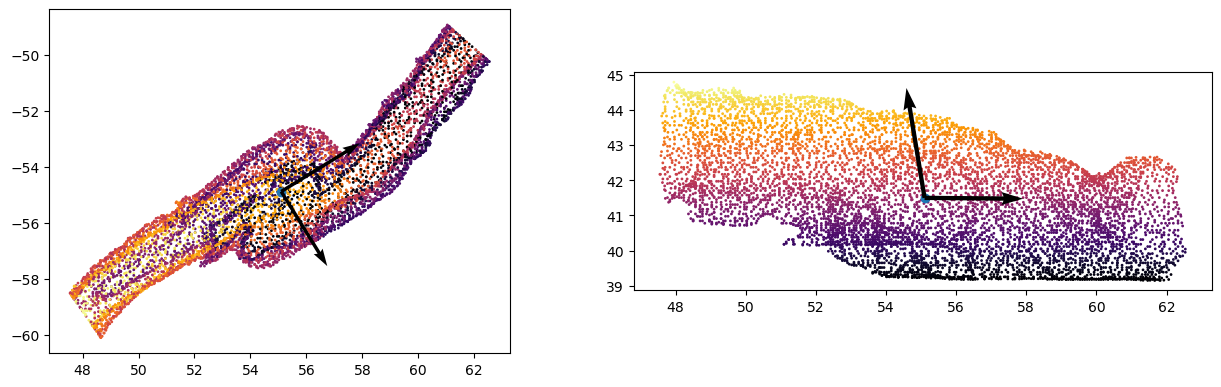

In [7]:
fig = plt.figure(figsize= (15, 10))
gs = gridspec.GridSpec(1,30)
ax1 = fig.add_subplot(gs[:, :12])
ax1.scatter(pc[::10, 0], pc[::10, 1], s = 1,c = pc[::10, 2], cmap= "inferno")
ax1.scatter(C[0], C[1])
ax1.quiver(C[0], C[1],S[0, 0], S[0, 1],  scale=5)
ax1.quiver(C[0], C[1],S[1, 0], S[1, 1],  scale=5)
ax1.set_aspect("equal")

ax2 = fig.add_subplot(gs[:, 15:])
ax2.scatter(pc[::10, 0], pc[::10, 2], s = 1,c = pc[::10, 2], cmap= "inferno")
ax2.scatter(C[0], C[2])
ax2.quiver(C[0], C[2],S[0, 0], S[0, 2],  scale=5)
ax2.quiver(C[0], C[2],S[2, 0], S[2, 2],  scale=5)
ax2.set_aspect("equal")

In [8]:
# we can express the point cloud in the normal basis. 
pc_norm = S @ X.T

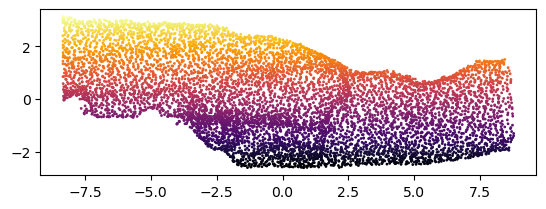

In [9]:
fig, ax = plt.subplots()

ax.scatter(pc_norm[0, ::10],pc_norm[2, ::10], s = 1,c = pc_norm[2, ::10], cmap= "inferno")
ax.set_aspect("equal")

In [10]:
# a sensible first guess for where a starting point can be is 
# by measuring the width of the point cloud in any direction normal to the largest eigenvector.
# we need to find a suitable threshold for the first point to choose (wherever the cut is at 
# an angle to the passage, the width will steadily increase and reach a plateau)
# first decile of width 

increment = 0.08
bins = np.arange(np.min(pc_norm[0]), np.max(pc_norm[0]), increment)
cloud_strips = np.empty_like(bins)

for k, i in enumerate(bins):
    extracted = pc_norm[1,np.abs(pc_norm[0] - i) < increment]
    cloud_strips[k] = np.max(extracted) - np.min(extracted)


In [11]:
wide_enough =  cloud_strips - np.quantile(cloud_strips, 0.1)> -0.2
start =np.min(np.argwhere(wide_enough))
end =np.max(np.argwhere(wide_enough))

Text(0, 0.5, 'point cloud width')

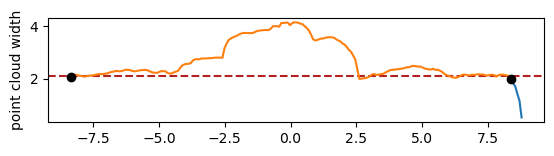

In [12]:
fig, ax = plt.subplots()
ax.axhline(np.quantile(cloud_strips, 0.1), ls = "--", color ="firebrick")

ax.plot(bins[~wide_enough], cloud_strips[~wide_enough])
ax.plot(bins[wide_enough], cloud_strips[wide_enough])
ax.scatter(bins[start], cloud_strips[start], zorder = 10, color = "k")
ax.scatter(bins[end], cloud_strips[end], zorder = 10, color = "k")
ax.set_aspect("equal")
ax.set_ylabel("point cloud width")

Now we may extract some coordinates for the start / end of our centreline. They are expressed in the normal basis. To find their real world coordinates, we back transform them.  

In [13]:
start_coords = S.T @ np.array([bins[start]+10*increment,0,0]) + C
end_coords = S.T @ np.array([bins[end]-10*increment,0,0]) + C   

In [14]:
# we calculate the very first mesh intersection, but the result is an unordered set of points. 

plane = pv.Plane(start_coords, S[:, 0], 20, 20, 100, 100).extract_surface().triangulate()
inter, _, _ = mesh.intersection(plane, split_first = False, split_second = False)

In [15]:
inter_pca = (S.T @ (inter.points.T - np.expand_dims(C, -1))).T
inter_pca_reordered = reorder_points(inter_pca, 100)

In [16]:
C_pca = np.mean(inter_pca_reordered, axis = 0)

In [17]:
# define orthogonal unit vectors in horizontal plane 
d0 = np.array([1,0,0])
d1 = np.array([0,0,1])

# project the section-normal vectors onto horizontal plane. 
horiz_dip_dir = np.asarray((S[:, 0].dot(d0), S[:, 0].dot(d1), 0)).T

R1 =  RotateFromTo(S[:, 0], horiz_dip_dir, verbose=False)
inter_vertical = R1 @ (inter_pca_reordered.T - np.expand_dims(C_pca, -1))
R2 = RotateFromTo(horiz_dip_dir, d1)
inter_rotated = R2 @ inter_vertical
cog_rotated = centre_of_gravity(inter_rotated.T)

print("mean coords of rotated section", np.mean(inter_rotated, axis = 1))
cog_in_pca = (R1.T @ R2.T @ cog_rotated) + C_pca

print("cog in PCA", cog_in_pca)
print("cog in real coordinates", S @ cog_in_pca+ C)
coord_init1 = S @ cog_in_pca+ C
print(start_coords)
coord_init = start_coords

mean coords of rotated section [ 1.85315956e-06  3.23101097e-06 -6.11540318e-06]
cog in PCA [-7.46411963 -0.02820965  0.28874959]
cog in real coordinates [ 48.72322595 -58.49755016  42.93835088]
[ 48.66596352 -58.83475913  41.55390802]


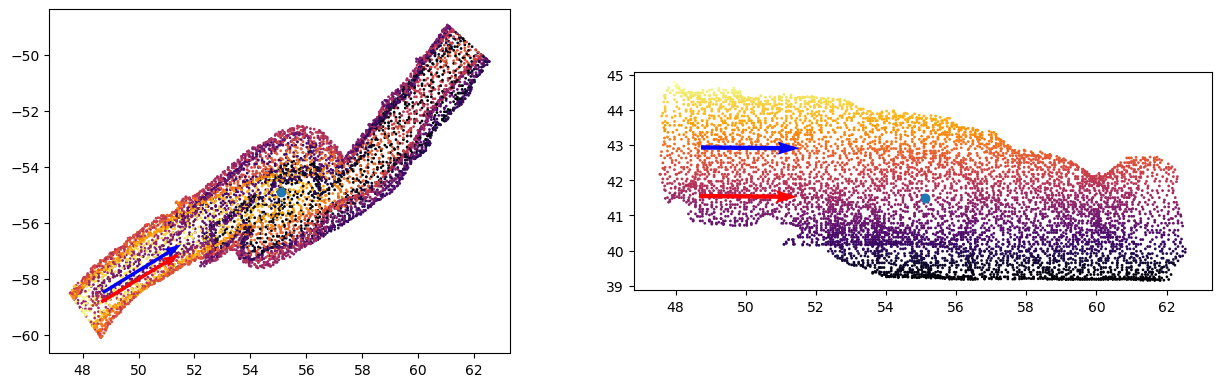

In [18]:
fig = plt.figure(figsize= (15, 10))
gs = gridspec.GridSpec(1,30)
ax1 = fig.add_subplot(gs[:, :12])
ax1.scatter(pc[::10, 0], pc[::10, 1], s = 1,c = pc[::10, 2], cmap= "inferno")
ax1.scatter(C[0], C[1])
ax1.quiver(coord_init[0], coord_init[1],S[0, 0], S[0, 1],  scale=5, color = "r")
ax1.quiver(coord_init1[0], coord_init1[1],S[0, 0], S[0, 1],  scale=5, color = "b")
ax1.set_aspect("equal")

ax2 = fig.add_subplot(gs[:, 15:])
ax2.scatter(pc[::10, 0], pc[::10, 2], s = 1,c = pc[::10, 2], cmap= "inferno")
ax2.scatter(C[0], C[2])
ax2.quiver(coord_init[0], coord_init[2],S[0, 0], S[0, 2],  scale=5, color = "r")
ax2.quiver(coord_init1[0], coord_init1[2],S[0, 0], S[0, 2],  scale=5, color = "b")
ax2.set_aspect("equal")

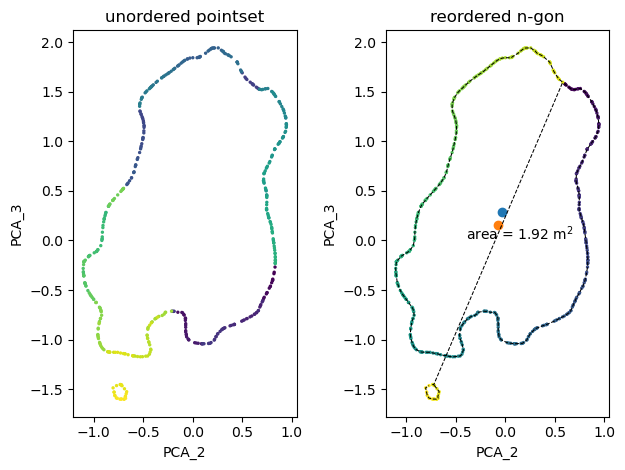

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)

cog = centre_of_gravity(inter_rotated)

ax1.scatter(inter_pca[:, 1], inter_pca[:, 2], c = np.arange(inter_pca.shape[0]), label = "unordered", s = 2)
ax1.set_aspect("equal")
ax1.set_xlabel("PCA_2")
ax1.set_ylabel("PCA_3")
ax1.set_title("unordered pointset")

ax2.scatter(inter_pca_reordered[:, 1], inter_pca_reordered[:, 2], c = np.arange(inter_pca_reordered.shape[0]), label = "reordered", s = 2)
ax2.plot(inter_pca_reordered[:, 1], inter_pca_reordered[:, 2], ls = "--", lw=0.75, color = "k")

area = computePolygonArea(np.vstack([inter_rotated[0],inter_rotated[2]]).T)

ax2.text(-0.4,0.0,f"area = {area:.2f} m$^2$")

# we need to now move our origin to the centre of gravity of this section. 
ax2.scatter(cog_in_pca[1], cog_in_pca[2])
ax2.scatter(np.mean(inter_pca_reordered, axis = 0)[1], np.mean(inter_pca_reordered, axis = 0)[2])
ax2.set_aspect("equal")
ax2.set_xlabel("PCA_2")
ax2.set_ylabel("PCA_3")
ax2.set_title("reordered n-gon")

plt.tight_layout()

In [20]:
def find2more(Nx,Ny,Nz):
    S1 = np.array([Nx, Ny, Nz])
     # we now find a transform that can express the 3d coordinates of the section as that of a plane. 
    if np.allclose(np.array([Nx, Ny]), np.zeros(2), 1e-1) != True:
        S2 = np.array([-Ny, Nx, 0])
        S3 = np.cross(S1, S2)
    elif np.allclose(np.array([Ny, Nz]), np.zeros(2), 1e-1) != True:
        S2 = np.array([0, Nz, -Ny])
        S3 = np.cross(S1, S2)
    else:
        S2 = np.array([-Nz, 0, Nx])
        S3 = np.cross(S1, S2)

    # we now have an orthonormal basis to express the section in real coordinates.
    S = np.vstack([S1, S2, S3]).T
    S = S / np.linalg.norm(S, axis = 0)

    return S

Brute forcing a best-looking vector. 
From our initial guess (1, 0, 0) in normed basis, we can calculate some equally spread apart vectors.  
With zero zaw, fixed pitch, increasing roll. 
We estimate 18 sections. 

In [21]:
# now we define the objective function to minimize. 

def section_area(x, p, C_pca):
    orig = p
    Nx, Ny, Nz = x
    S1 = x
    print(S1)
    plane = pv.Plane(orig, x, 20, 20, 100, 100).extract_surface().triangulate()
    inter, _, _ = mesh.intersection(plane, split_first = False, split_second = False)

    S_prime = find2more(Nx, Ny, Nz)

    inter_pca = (S_prime.T @ (inter.points.T - np.expand_dims(C_pca, -1))).T
    inter_pca_reordered = reorder_points(inter_pca, 0)
    C_rotation = np.mean(inter_pca_reordered, axis = 0)
    # define orthogonal unit vectors in horizontal plane 
    d0 = np.array([1,0,0])
    d1 = np.array([0,0,1])

    # project the section-normal vectors onto horizontal plane. 
    horiz_dip_dir = np.asarray((S1.dot(d0), S1.dot(d1), 0)).T

    R1 =  RotateFromTo(S[:, 0], horiz_dip_dir, verbose=False)
    inter_vertical = R1 @ (inter_pca_reordered.T - np.expand_dims(C_rotation, -1))
    R2 = RotateFromTo(horiz_dip_dir, d1)
    inter_rotated = R2 @ inter_vertical
    
    area = computePolygonArea(inter_rotated[[0, 2]].T)
    
    return area

In [22]:
def rotate_pitch_roll(a, pitch, roll):
    Rx = np.array([[1, 0, 0],
                  [0, np.cos(roll), -np.sin(roll)],
                  [0, np.sin(roll), np.cos(roll)]])
    Ry = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                  [0, 1, 0],
                  [-np.sin(pitch), 0, np.cos(pitch)]])

    rot = Ry @ Rx
    b = rot.T @ a

    return b

In [23]:
# for one iteration, start with the vector normal and update. 
# define the angular search radius. 
disp = 0.5
coord_init = coord_init1
coords = []
coords.append(coord_init)
v_init = np.array([1, 0, 0])
rad = np.pi / 10
print(S @ v_init)
best_area = section_area(S @ v_init, coord_init, C)
print(f"best area: {best_area:.2f}")

[ 0.8521502   0.49923882 -0.15684587]
[ 0.8521502   0.49923882 -0.15684587]
best area: 1.88


In [ ]:
step = 0
numIter = 1
numSteps = 10

while step < numSteps:
    print(f"coordonnées de départ, step {step}", coord_init)

    iter = 0
    
    while iter < numIter:
        k = 0
        
        out = np.zeros((19, 3))
        out[k] = [best_area, 0, 0]
        
        for pitch, shift in tqdm(zip((rad /3, rad /2, rad), (0, np.pi /6, 0)), total=18):
            for roll in np.linspace(0, 2* np.pi - np.pi / 3, 6):
                roll -= shift
                k+=1
                
                v = rotate_pitch_roll(v_init, pitch, roll)
    
                # rotate v to be in real coordinates. 
                v_real = S @ v
    
                area = section_area(v_real, coord_init, C)
                out[k] = [area, pitch, roll]
        
        best_pitch, best_roll = out[np.argmin(out[:, 0])][1:]
    
    
        # update the vector.
        v_init = rotate_pitch_roll(v_init, best_pitch, best_roll)
        # update the search radius
        rad /= 2
        # update the best area
        best_area = section_area(S @ v_init, coord_init, C)
        print(f"Iteration {iter}\nbest area: {best_area:.3f}, pitch and roll: {best_pitch:.3f}, {best_roll:.3f}")
    
        # update the counter
        iter+=1
    
    print("this is our updated best looking-vector", v_init)

    # we take a section in this best looking vector. 
    plane = pv.Plane(coord_init, v_init, 20, 20, 100, 100).extract_surface().triangulate()
    inter, _, _ = mesh.intersection(plane, split_first = False, split_second = False)

    S_prime = find2more(*v_init)

    inter_pca = (S_prime.T @ (inter.points.T - np.expand_dims(C, -1))).T
    inter_pca_reordered = reorder_points(inter_pca, 0)
    C_rotation = np.mean(inter_pca_reordered, axis = 0)
    
    # define orthogonal unit vectors in horizontal plane 
    d0 = np.array([1,0,0])
    d1 = np.array([0,0,1])

    # project the section-normal vectors onto horizontal plane. 
    horiz_dip_dir = np.asarray((v_init.dot(d0), v_init.dot(d1), 0)).T

    R1 =  RotateFromTo(S[:, 0], horiz_dip_dir, verbose=False)
    inter_vertical = R1 @ (inter_pca_reordered.T - np.expand_dims(C_rotation, -1))
    R2 = RotateFromTo(horiz_dip_dir, d1)
    inter_rotated = R2 @ inter_vertical

    cog_rotated = centre_of_gravity(inter_rotated.T)

    print("mean coords of rotated section", np.mean(inter_rotated, axis = 1))
    cog_in_pca = (R1.T @ R2.T @ cog_rotated) + C_pca

    print("cog in PCA", cog_in_pca)
    print("cog in real coordinates", S @ cog_in_pca+ C)
    coord_init = S @ cog_in_pca+ C +v_init*disp
    print("now moving to next section", coord_init)
    
    coords.append(coord_init)
    step+= 1
    


coordonnées de départ, step 0 [ 48.72322595 -58.49755016  42.93835088]


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

[ 0.84674609  0.52897435 -0.05663208]
[ 0.89448089  0.43951706 -0.08202854]
[ 0.89521684  0.40704664 -0.1813831 ]
[ 0.84821798  0.46403352 -0.25534122]
[ 0.80048317  0.55349082 -0.22994476]
[ 0.79974722  0.58596123 -0.13059019]


  6%|████▌                                                                              | 1/18 [00:01<00:26,  1.55s/it]

[ 0.79977782  0.59844361 -0.04712412]
[ 0.88163214  0.47190899 -0.00516457]
[ 0.92351314  0.36655774 -0.11295529]
[ 0.88353982  0.38774111 -0.26270555]
[ 0.8016855   0.51427573 -0.30466509]
[ 0.7598045   0.61962698 -0.19687438]


 11%|█████████▏                                                                         | 2/18 [00:03<00:33,  2.07s/it]

[0.80826732 0.57079647 0.14455215]
[0.94938551 0.30633429 0.06947273]
[ 0.95156119  0.21034215 -0.2242487 ]
[ 0.81261868  0.37881219 -0.44289071]
[ 0.67150049  0.64327437 -0.3678113 ]
[ 0.66932481  0.73926651 -0.07408987]


 17%|█████████████▊                                                                     | 3/18 [00:06<00:33,  2.20s/it]


[ 0.67150049  0.64327437 -0.3678113 ]
Iteration 0
best area: 1.451, pitch and roll: 0.314, 4.189
this is our updated best looking-vector [ 0.95105652 -0.26761657 -0.1545085 ]
mean coords of rotated section [-1.56580369e-15 -4.37713305e-15 -1.10317987e-15]
cog in PCA [-7.46411266 -0.15514734  0.27777407]
cog in real coordinates [ 48.65688902 -58.39828042  42.89386974]
now moving to next section [ 49.13241728 -58.5320887   42.8166155 ]
coordonnées de départ, step 1 [ 49.13241728 -58.5320887   42.8166155 ]


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

[ 0.67692866  0.66218826 -0.32136317]
[ 0.69758008  0.71540132 -0.03978649]
[0.83687452 0.53140372 0.13134351]
[0.95551755 0.29419304 0.02089684]
[ 0.93486613  0.24097997 -0.26067984]
[ 0.79557168  0.42497758 -0.43180984]


  6%|████▌                                                                              | 1/18 [00:02<00:44,  2.64s/it]

[ 0.71920789  0.57181105 -0.39467977]
[ 0.67577076  0.71917733 -0.1616101 ]
[0.77483782 0.62675903 0.08245885]
[0.91734201 0.38697443 0.09345813]
[ 0.96077914  0.23960814 -0.13961155]
[ 0.86171208  0.33202645 -0.38368049]


 11%|█████████▏                                                                         | 2/18 [00:05<00:42,  2.64s/it]

[ 0.68105857  0.69630245 -0.22654383]
[0.74769375 0.66333976 0.030568  ]
[0.88769715 0.44806284 0.10598804]
[ 0.96106536  0.26574861 -0.07570376]
[ 0.89443017  0.2987113  -0.3328156 ]
[ 0.75442678  0.51398822 -0.40823563]


 17%|█████████████▊                                                                     | 3/18 [00:07<00:39,  2.65s/it]


[ 0.67150049  0.64327437 -0.3678113 ]
Iteration 0
best area: 1.478, pitch and roll: 0.000, 0.000
this is our updated best looking-vector [ 0.95105652 -0.26761657 -0.1545085 ]
mean coords of rotated section [-1.82524739e-15 -2.12945529e-15  3.59617195e-15]
cog in PCA [-7.46411166e+00 -6.70624483e-03  1.58787532e-01]
cog in real coordinates [ 48.73539941 -58.5553106   42.8205881 ]
now moving to next section [ 49.21092767 -58.68911888  42.74333386]
coordonnées de départ, step 2 [ 49.21092767 -58.68911888  42.74333386]


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

[ 0.67449369  0.65288086 -0.34468075]
[ 0.68371129  0.72752146 -0.05702091]
[0.82282945 0.55130143 0.1379073 ]
[0.95273002 0.3004408  0.04517567]
[ 0.94351243  0.2258002  -0.24248417]
[ 0.80439426  0.40202023 -0.43741238]


  6%|████▌                                                                              | 1/18 [00:02<00:45,  2.68s/it]

[ 0.72599675  0.54453759 -0.42000895]
[ 0.66286559  0.72234793 -0.19703468]
[0.75185614 0.65527698 0.07296856]
[0.90397786 0.4103957  0.11999754]
[ 0.96710902  0.23258536 -0.10297673]
[ 0.87811846  0.29965631 -0.37297997]


 11%|█████████▏                                                                         | 2/18 [00:05<00:42,  2.65s/it]

[ 0.67880372  0.67119017 -0.29787454]
[ 0.71092168  0.70291441 -0.02239842]
[0.85039291 0.51111697 0.12486529]
[ 0.95774618  0.28759531 -0.00334711]
[ 0.92562822  0.25587107 -0.27882322]
[ 0.78615699  0.44766851 -0.42608694]


 17%|█████████████▊                                                                     | 3/18 [00:07<00:39,  2.66s/it]


[ 0.72599675  0.54453759 -0.42000895]
Iteration 0
best area: 1.462, pitch and roll: 0.039, -0.524
this is our updated best looking-vector [ 0.95638926 -0.17323721 -0.23517749]
mean coords of rotated section [ 1.34427004e-15  1.92038577e-15 -7.05741771e-15]
cog in PCA [-7.46411185 -0.07668527  0.21551761]
cog in real coordinates [ 48.69838331 -58.48108454  42.85574013]
now moving to next section [ 49.17657794 -58.56770314  42.73815139]
coordonnées de départ, step 3 [ 49.17657794 -58.56770314  42.73815139]


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

[ 0.72846189  0.54992858 -0.40856067]
[ 0.67105684  0.71700791 -0.18863288]
[0.76013567 0.64604191 0.0694521 ]
[0.90661956 0.40799659 0.10760931]
[ 0.9640246   0.24091726 -0.11231848]
[ 0.87494577  0.31188326 -0.37040347]


  6%|████▌                                                                              | 1/18 [00:02<00:46,  2.72s/it]

[ 0.79879572  0.42842064 -0.42235192]
[ 0.68436843  0.65723664 -0.31572113]
[ 0.70433764  0.70849579 -0.04407022]
[0.83873413 0.53093895 0.1209499 ]
[0.95316142 0.30212295 0.01431911]
[ 0.93319221  0.2508638  -0.2573318 ]


 11%|█████████▏                                                                         | 2/18 [00:05<00:42,  2.66s/it]

[ 0.73297071  0.56049899 -0.38547997]
[ 0.68706917  0.7060202  -0.17167242]
[0.77632536 0.62722923 0.06246934]
[0.91148309 0.40291705 0.08280354]
[ 0.95738463  0.25739584 -0.13100402]
[ 0.86812844  0.33618681 -0.36514577]


 17%|█████████████▊                                                                     | 3/18 [00:07<00:39,  2.66s/it]


[ 0.72599675  0.54453759 -0.42000895]
Iteration 0
best area: 1.479, pitch and roll: 0.000, 0.000
this is our updated best looking-vector [ 0.95638926 -0.17323721 -0.23517749]
mean coords of rotated section [ 7.10542736e-16  6.86857978e-16 -3.22112707e-15]
cog in PCA [-7.46411191 -0.04539765  0.20215298]
cog in real coordinates [ 48.7148486  -58.51054362  42.85142913]
now moving to next section [ 49.19304323 -58.59716222  42.73384039]
coordonnées de départ, step 4 [ 49.19304323 -58.59716222  42.73384039]


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

[ 0.72724684  0.5472418  -0.41429269]
[ 0.66697649  0.71969083 -0.19284047]
[0.75601115 0.65067389 0.07120831]
[0.90531615 0.40920791 0.11380486]
[ 0.9655865   0.23675888 -0.10764735]
[ 0.87655184  0.30577583 -0.37169613]


  6%|████▌                                                                              | 1/18 [00:02<00:45,  2.66s/it]

[ 0.79946883  0.42099167 -0.4285039 ]
[ 0.68011134  0.65742903 -0.3244004 ]
[ 0.69755799  0.71503364 -0.0462571 ]
[0.83436214 0.5362009  0.1277827 ]
[0.95371962 0.29976354 0.02367919]
[ 0.93627297  0.24215892 -0.25446411]


 11%|█████████▏                                                                         | 2/18 [00:05<00:42,  2.65s/it]

In [50]:
coords

[array([ 48.72322595, -58.49755016,  42.93835088]),
 array([ 48.71075153, -58.44831335,  42.78326032]),
 array([ 48.71087285, -58.45062266,  42.77656265]),
 array([ 48.71404298, -58.46393853,  42.75140595]),
 array([ 48.71270457, -58.45061378,  42.78654829]),
 array([ 48.71072811, -58.45262446,  42.76940332]),
 array([ 48.7139724 , -58.46135898,  42.75922995]),
 array([ 48.71439643, -58.45739066,  42.77417119]),
 array([ 48.718431  , -58.46401962,  42.77498914]),
 array([ 48.71085116, -58.44693803,  42.78817653]),
 array([ 48.72367169, -58.47084084,  42.78174648])]

[[ 48.72322595 -58.49755016  42.93835088]
 [ 48.71075153 -58.44831335  42.78326032]
 [ 48.71087285 -58.45062266  42.77656265]
 [ 48.71404298 -58.46393853  42.75140595]
 [ 48.71270457 -58.45061378  42.78654829]
 [ 48.71072811 -58.45262446  42.76940332]
 [ 48.7139724  -58.46135898  42.75922995]
 [ 48.71439643 -58.45739066  42.77417119]
 [ 48.718431   -58.46401962  42.77498914]
 [ 48.71085116 -58.44693803  42.78817653]
 [ 48.72367169 -58.47084084  42.78174648]]


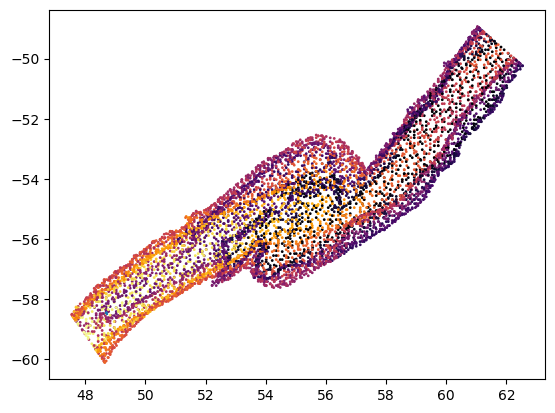

In [52]:
fig, ax = plt.subplots()

centreline = np.array(coords)
print(centreline)

ax.plot(centreline[:, 0], centreline[:, 1])
ax.scatter(pc[::10, 0], pc[::10, 1], s = 1,c = pc[::10, 2], cmap= "inferno")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.sin(out[:, 1])*np.cos(out[:, 2]),np.sin(out[:, 1]) *np.sin(out[:, 2]), c= out[:, 0])
ax.set_xlabel("pitch")
ax.set_ylabel("roll")
ax.set_aspect("equal")

In [ ]:
res = minimize(objective, x0 = S[:, 0], args=cog_coords)

In [ ]:
S[:, 0]

In [ ]:
# we calculate the very first mesh intersection, but the result is an unordered set of points. 

plane = pv.Plane(start_coords, res.x, 20, 20, 100, 100).extract_surface().triangulate()
inter, _, _ = mesh.intersection(plane, split_first = False, split_second = False)

S = find2more(*res.x)

inter_pca = (S.T @ (inter.points.T - np.expand_dims(C, -1))).T
inter_pca_reordered = reorder_points(inter_pca[:, 1:], 0)
    
area = computePolygonArea(inter_pca_reordered)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(inter_pca_reordered[:, 0], inter_pca_reordered[:, 1])

In [ ]:
S.T @ np.array([1, 0, 0])

In [ ]:
S[:, 0]